# Time-Series NDVI Analysis and Prediction in GEE Platform

**Author: Md Saimoom Ferdous**

Normalized Difference Vegetation Index (NDVI) is a satellite image derived indicator that measures state of the plant health. NDVI is directly related to drought condition. During rainy season, higher NDVI  is observed (maximum is +1) whereas in the dry season NDVI drops (minimum is -1). NDVI is seen seasonal in nature but due to climate change upward/downward changes are also observed over the years. Knowing the trend and seasonal cycle of NDVI in advanced can help better resource planning and deployment for the local and national stake holders. There are many known and unknown parameters influence NDI. Out of many approaches, one would be training machine learning models with past tdata to get prediction. This notebook will outline two of the machine learning approaches for NDVI prediction.

In the first part, NDVI was extracted from time-series Landsat 8 data image data in Google Earth Engine (GEE) platform through Python API. In the next part, predictive models were built to forecast NDVI using conventional ARIMA and state of the art FBProphet models. Comparison of the performance metrics puts FBProphet ahead of the ARIMA model.


## 1. Data Loading

In [2]:
# Import relevant libraries

import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

ee.Initialize()

### Select Region

Okanagan valley, BC, Canada was chosen as test site. Out of BC, this region gets the most sunshine throught the year. This is desired as optical satellite image data will be used and least cloud cover is highly dersirbale.

In [3]:
# Visualize the Area Of Interest (AOI) in the map

okanagan_map = folium.Map(location=[49.888056, -119.495556], zoom_start=10)
okanagan_map

### Landsat 8 Image Collection

Landsat 8 is operational since 2013. we will be taking every images till date with maximum allowable cloud cover of 20%

In [4]:
# Landsat 8 surface reflectance imagery
# Take images upto 20% cloud coverage
# Take 7 years image data starting at 2013

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").\
          filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2013-01-01','2021-01-01')   


# setting the Area of Interest (AOI)
okanagan_AOI = ee.Geometry.Rectangle([-119.28, 49.99,
                                    -119.60, 49.69])
# filter area
landsat_AOI = landsat.filterBounds(okanagan_AOI)


#### Total Number of Images in the Image Collection

In [5]:
print('Total number of images :', landsat_AOI.size().getInfo())

Total number of images : 97


#### Band Information

In [6]:
# Names of each Landsat 8 band

landsat_AOI.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa']

- B5 is the Near Infrared (NIR) band
- B4, B3 and B2 are the Red, green and Blue bands respectively

#### Plot the First Image

In [7]:
# Plot the 'first' image in the collection

# List of images
listOfImages = landsat_AOI.toList(landsat_AOI.size())

# Plot in RGB color composite
palette = ['red', 'green', 'blue']
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': okanagan_AOI}
             
okanagan_map.addLayer(ee.Image(listOfImages.get(1)), parameters)
okanagan_map

- The image is down centred around Okanagan lake

## 2. NDVI Analysis

NDVI of every image pixels in the images will be calculated by the equation:
\begin{equation}
NDVI = \frac{NIR - Red}{NIR + Red}
\end{equation}

Where, NIR is B5 band and Red is B4 band.
Average NDVI will be calculated on every images to get time-series NDVI of the AOI.

### NDVI Calculation

In [8]:
# Function to calculate 'NDVI' and add a additional band to every images in the collection

def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [9]:
# Function to calculate 'average NDVI' on every images in the collection

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = okanagan_AOI,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True);
    return meanDict.get('NDVI').getInfo()


In [10]:
# Calculate 'average NDVI' for every images

listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_coll = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_coll.append(temp_ndvi)

In [11]:
# Extract 'dates' from the image collection

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

#### Time-series NDVI Dataframe

In [12]:
# Make a dataframe with 'day' and 'NDVI' columns

ndvi_df = pd.DataFrame(ndvi_coll, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(5)

,ndvi
2013-03-30,0.305561
2013-07-03,0.724109
2013-07-19,0.388507
2013-07-28,0.555191
2013-08-13,0.312616


### Up-sample to Get Daily NDVI Data

Our goal is to train algorithm to predict NDVI which requires the data to have regular interval such as daily, weekly and such. Filtering the data by cloud cover percentage yields irregular interval NDVI data. In this section, we will up-sample to get daily NDVI data with linear interpolation.

In [13]:
# Up-sampple the date column

ndvi_df_daily = ndvi_df.resample('D').median()

# Linear interpolate NDVI data

ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily.head(5)

,ndvi
2013-03-30,0.305561
2013-03-31,0.309967
2013-04-01,0.314373
2013-04-02,0.318779
2013-04-03,0.323185


#### Plot Interpolated NDVI Data

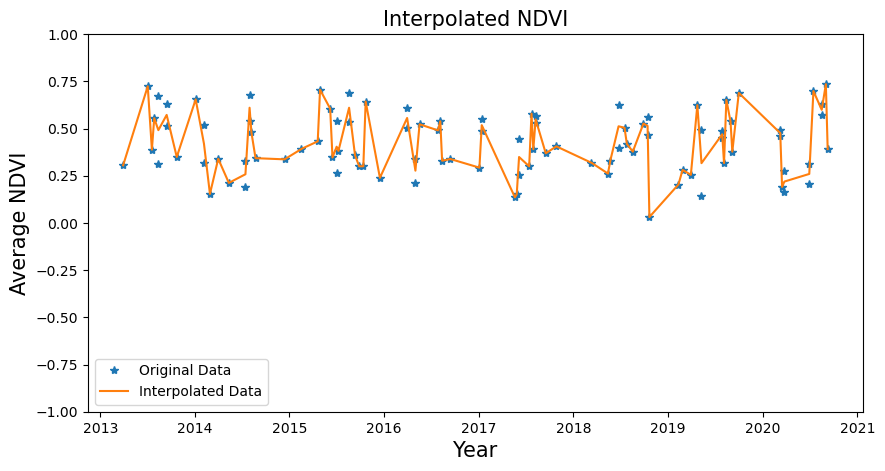

In [14]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ndvi_df, '*')
plt.plot(ndvi_df_daily)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

- Interpolated data aligns well with the original data which is sufficient to train algorithm for prediction

## 3. NDVI Prediction Modelling

There are many popular algorithms for time-series modelling of which ARIMA is the most popular conventional model. We will be using this for NDVI prediction modleling. Another state of the art tool for prediction is FBProphet which takes into account uncertain events that the conventional model fails to account for. 

### ARIMA Model


ARIMA stands for Auto Regressive Integrated Moving Average. General ARIMA model can be expressed as:

**predicted Y(t) = constant + linear combination lags of Y(t) (p lags) + linear combination lags of error in prediction terms (q lags)**

For example, Y(t) = 5 + 3 Y(t-1) + 2 $\phi$(t-1). 

Here, p=q=1. d stands for difeerencing needed for Y(t) to make the stationary.

There are many ways to determine best possible combinations of p, d and q values for a ARIMA model given a time seris data. One way would be manually plotiing auto correlation function (ACF) and partial autocorrelation function (PACF) for combinations of p, d and q parameters and determine the case for near zero ACF and PACF values. Here we will use auto_arima function that will output best optimized model parameters for ranges of p, q values based on Akaike Information Criterion (AIC). AIC is an estimator which assess the statistical quality of a model. Model with a lower AIC value results in the best fit with the training data with least features. 

The auto_arima function can do the grid search over p, d, q (related to ARIMA model) and P, D and Q (related to seasonal components) parameters then report back the model with best AIC value. 

#### Seasonal Decomposition

Let's see the trend and seasonality components from the time-series NDVI data

- **Trend:** NDVI tendency over a period of time. e.g. if the NDVI is increasing/decreasing over a year
- **Seasonality:** periodic variation in the NDVI that we see every year. It tells which part of the year NDVI increases/decreases and that happens in cyclic manner over the years
- **Residual:** non systematic component of the NDVI value which is not structured and termed as noise

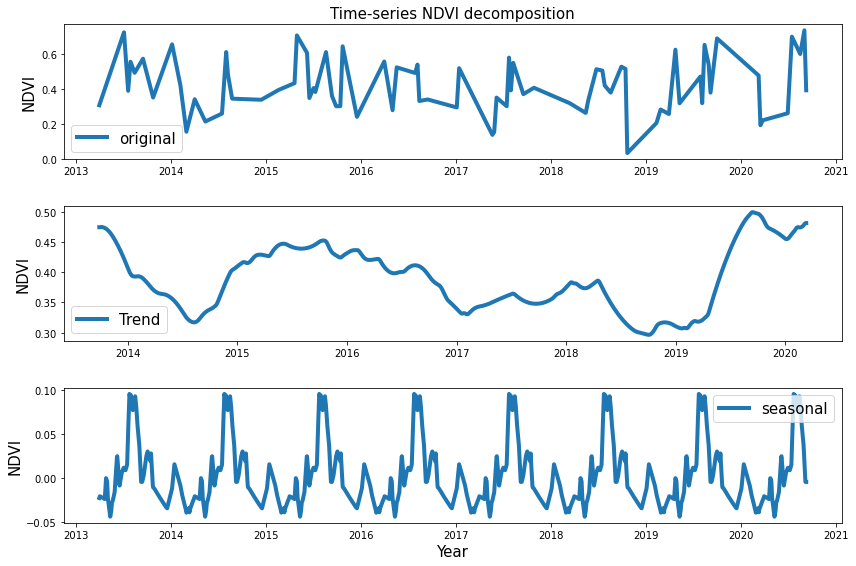

In [15]:
# Apply decompomposition on NDVI data

decomposition = seasonal_decompose(ndvi_df_daily, model= 'additive', period = 365)    # additive worked better in terms of seasonality decomposition
                                                            # compared to multiplicative

# assign trend, seasonal components from decomposed data 

trend = decomposition.trend
seasonal = decomposition.seasonal


# Plot the original data, the trend, the seasonality, and the residual

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ndvi_df_daily, label = 'original', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Time-series NDVI decomposition', fontsize=15)
plt.subplot(412)
plt.plot(trend, label = 'Trend', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()

- The NDVI has decreasing trend from 2015 to 2019. From 2019 till today it shows increasing trend. This interesting trend could be further explored to relate causations.
- Seasonality is constant over time but follows strictly cyclic manner. That is every year there are specific times when NDVI rises and falls

#### NDVI Trend for Two Years

Let's look closely at what is happeing in two years window. We will have broader picture on the seasonality.

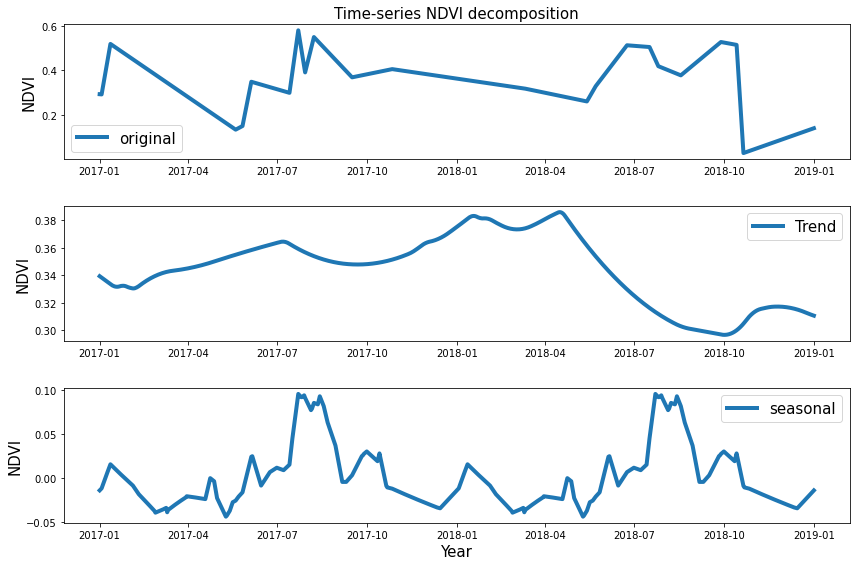

In [16]:
# Plot the original data, the trend, the seasonality data over two years

two_year = (ndvi_df_daily.index>='2017-01-01') & (ndvi_df_daily.index<='2019-01-01')

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ndvi_df_daily[two_year], label = 'original', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Time-series NDVI decomposition', fontsize=15)
plt.subplot(412)
plt.plot(trend[two_year], label = 'Trend', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal[two_year], label = 'seasonal', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()

- Looking into the seasonality, NDVI hits lowest over fall and winter season whereas it hits during the summer season. This is expected given the geographical context of North America

#### Map Images with Low/High NDVI Values

We will pick a day in May and August of 2017 and plot NDVI map for this time period. 

In [17]:
# Pick two dates in May and August of 2017

low_index = day.index('2017-05-20')
high_index = day.index('2017-08-08')

In [18]:
# Fetch low/high NDVI images

ndvi_low = ee.Image(listOfImages_ndvi.get(low_index))
ndvi_high = ee.Image(listOfImages_ndvi.get(high_index))

In [19]:
# Plot low NDVI image

palette = ['red', 'yellow', 'green']
ndvi_parameters = {'min': -1,
                   'max': 1,
                   'dimensions': 512,
                   'palette': palette,
                   'region': okanagan_AOI}
okanagan_map.addLayer(ndvi_low, ndvi_parameters)
okanagan_map

In [20]:
# Plot high NDVI image

okanagan_map.addLayer(ndvi_high, ndvi_parameters)
okanagan_map

- Given the same scale, greenish spread is way more higher in August image than the May one

#### Train and Test Data Split

Split the first five years NDVI data for train set and rest of the three years for test data. 

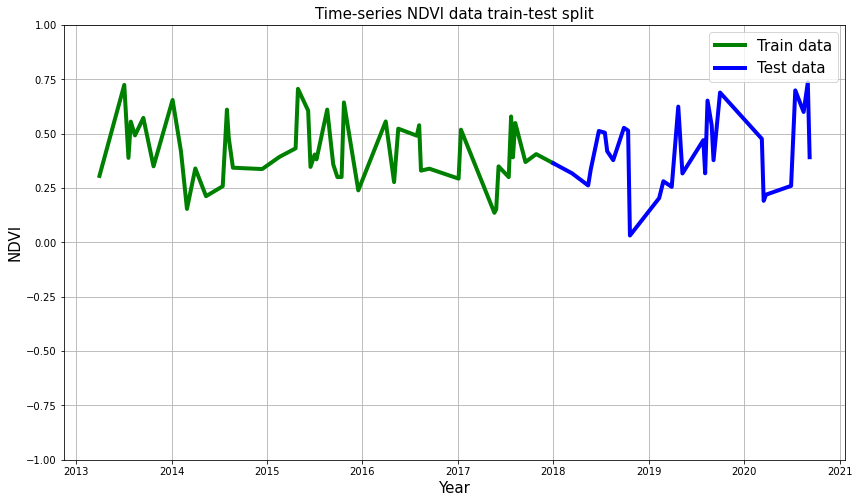

In [136]:
# split data into train and training set

 
train_data, test_data = ndvi_df_daily[ndvi_df_daily.index <= '2018-01-01'],\
                        ndvi_df_daily[ndvi_df_daily.index >= '2018-01-01']


# plot the training and testing data

plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.plot(train_data, 'green', label='Train data', linewidth=4)
plt.plot(test_data, 'blue', label='Test data', linewidth=4)
plt.title('Time-series NDVI data train-test split', fontsize=15)
plt.ylim([-1,1])
plt.legend(fontsize=15)
plt.show()

#### Train the Model

Determine best parameters to train ARIMA model with this dataset.

In [85]:
# fit auto_arima model

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, # minimum p, q values
                      test='adf',                              # uses ADF test to determine differencing order 'd'
                                                               # needed for statioraity
                      max_p=3, max_q=3,                        # maximum p and q values
                      m=7,                                    # frequency of series, m=7 for daily observation
                      d=1,                                     # one step differencing, d=1 can make the data stationary
                                                               # seen from pre-processing step
                      seasonal=True,                           # observed seasonality
                      start_P=0,                               
                      D=0,                                     # auto_arima will come back with optimal P, Q and D parameters
                                                               # when 'seasonal' parameter is turned on
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)                           # step vs parallel. step is recommended for quicker performance


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-11901.951, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-11842.656, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-14336.494, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-13182.863, Time=1.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-11844.625, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-14478.555, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-14508.752, Time=1.57 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-14504.716, Time=1.57 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-14505.492, Time=2.38 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-14503.573, Time=3.84 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=-14510.940, Time=2.35 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-14483.182, Time=0.18 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=-14507.612, Time=3.10 sec
 ARIMA(2,1,0)(0,0,2)[7] intercept   : AIC=-14507.292, Time=2.98 sec
 ARIM

No handles with labels found to put in legend.


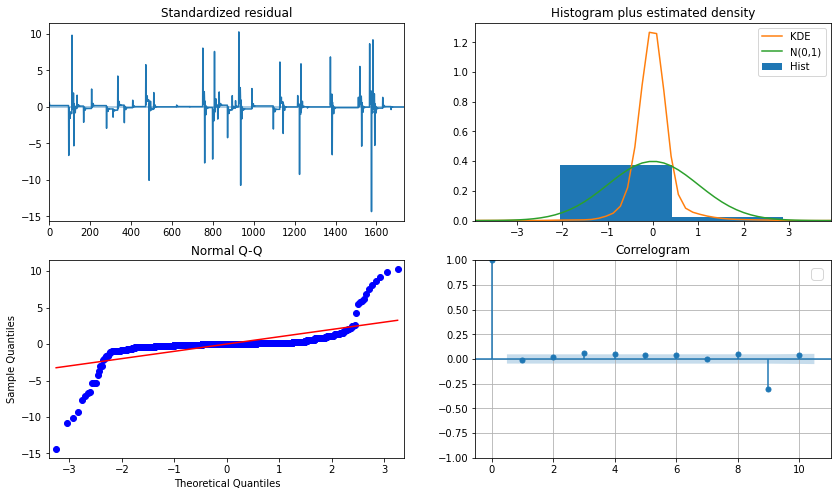

In [86]:
# Lets review the residual statistics from auto ARIMA model
# residuals should be closer to noise like statistics, which confirms not containing any information from the data

model_autoARIMA.plot_diagnostics(figsize=(14,8))
plt.grid(True)
plt.legend(fontsize=15)
plt.show()

Observations:
- **Top left**: residual values seem to fluctuate around zero values and uniform variance
- **Top right**: The density plot suggests resembleness of residual distribution (orange color) with normal distribution (green one), with a mean zero
- **Bottom left**: The blue dots should perfectly align with the red line for a ideal scenario. This is the best possible alignment we could get with the data
- **Bottom right**: The ACF of residuals are not correlated from the plot (except a slight spike at 9). Any correlation would suggest there are residual pattern in the data which is not not explained in the model and needs parameter adjustment
- Overall, it appears to be a good model and ready to use for forecasting

In [87]:
# Lets build the ARIMA model with best p, d, q parameters

model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.ndvi   No. Observations:                 1738
Model:                 ARIMA(2, 1, 0)   Log Likelihood                7245.593
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sat, 26 Sep 2020   AIC                         -14483.186
Time:                        03:12:30   BIC                         -14461.344
Sample:                    03-31-2013   HQIC                        -14475.109
                         - 01-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.733e-05      0.001      0.066      0.948      -0.001       0.001
ar.L1.D.ndvi     0.9378      0.024     39.192      0.000       0.891       0.985
ar.L2.D.ndvi    -0.0617      0.024     -2.57

#### Forecast with ARIMA Model

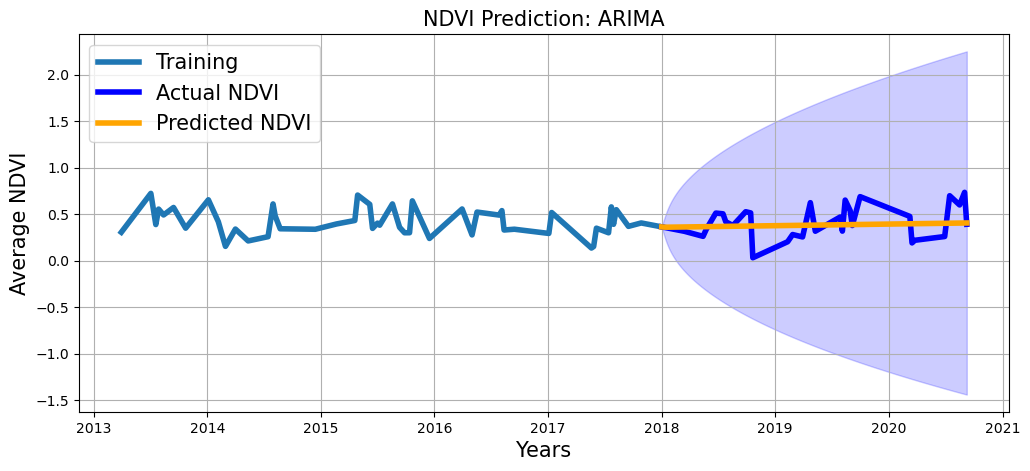

In [90]:
# Forecast

# generate forecast NDVI data

fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)               # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# plot the train, test and forecast data

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training', linewidth=4)
plt.plot(test_data, color = 'blue', label='Actual NDVI', linewidth=4)
plt.plot(fc_series, color = 'orange',label='Predicted NDVI', linewidth=4)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='blue', alpha=.2)
plt.title('NDVI Prediction: ARIMA', fontsize=15)
plt.grid(True)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.show()

- The 'yellow' line is the predicted NDVI with ARIMA model
- The shaded area is the 95% confidence region. It make sense as we move away from the beginning of prediction, the model loses its capability to confidently predict 
- It follows the trend but clearly not being able to follow seasonality in the graph

#### Look Closely on the Predicted Data

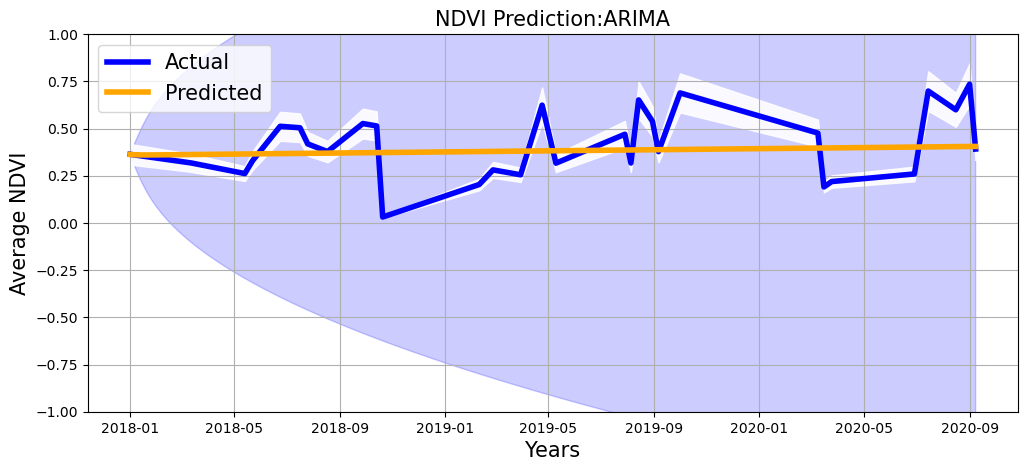

In [91]:
# plot only the train, test and forecast data for 2018-2020


# take forecast data for 2018-2020

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual', linewidth=4)
plt.plot(fc_series.index,fc_series.values, color = 'orange',label='Predicted', linewidth=4)
plt.fill_between(fc_series.index, lower_series, upper_series, 
                 color='blue', alpha=.2)
plt.title('NDVI Prediction:ARIMA', fontsize=15)
plt.grid(True)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.ylim((-1,1))
plt.legend(loc='upper left', fontsize=15)
plt.fill_between(fc_series.index,.85*test_data.ndvi,1.15*test_data.ndvi,
                 color='white', alpha=.90)
    
# save the plot
plt.show()

#### Model Performance

Model performance is evaluated by comparing predicted values with test data. Comaprison will be made in terms of Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE). Average of these metrics will be taken and named 'average_score' to get a sense of overall fit of the prediction with test data.

In [92]:
# function to report back the performance metrics of a function

def performance_measure(model, yhat, y):
    # mean squared error
    mse = mean_squared_error(y, yhat)
    #mean absolute error
    mae = mean_absolute_error(y, yhat)
    # root mean squared error
    rmse=np.sqrt(mse)
    #average score
    average=np.mean((mse, mae, rmse))
    # save model performance as dataframe
    metrics=pd.DataFrame({'model': model, 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'average_score':[average]})
    return metrics

In [93]:
# performance measures for the ARIMA model
fc_ARIMA = fc

ARIMA = performance_measure('ARIMA', fc_ARIMA, test_data)
ARIMA

,model,mse,mae,rmse,average_score
0,ARIMA,0.026408,0.136337,0.162506,0.108417


### FBProphet Modelling

Classic forecasting models such as ARIMA needs lots of parameter tuning and expert knowledge in statistics and analytics. Facebook developed a open source library called FBProphet, which requires very little domain knowlegde and easy to integrate in automated production environment. FBProphet decomposes any time series data into trend, seasonality, event or holidays components and can be written as:

Y(t) = T(t) + S(t) + H(t) + $\epsilon$

T(t): piecewise linear or logistic growth curve for modelling trend components
S(t): cyclic changes in the time-series (dily/weekly/monthly/quarterly)
H(t): effect of holidays or unscheduled events
$\epsilon$: noisy term that can not be modelled with equation

As opposed to time based dependance, FBProphet considers forecasting as curve fitting problem. 

In this section, FBProphet will be used to model Okanagan Valley's NDVI prediction. Modelling will be confined to a base model, but it could be expanded by integrating powerful tools FBProphet offers such as considering saturating growth, trend change and special events effect.

#### Data Preparation

Rename the NDVI dataframe colums to 'ds' and 'y' to be compatible with FBProphet model

In [94]:
# rearrange data to suit Prophet model

# rename columns from date and close to ds and y

train_data_fb = train_data.reset_index()
train_data_fb.rename(columns={"index": "ds", "ndvi": "y"},inplace=True)
train_data_fb.head(5)

,ds,y
0,2013-03-30,0.305561
1,2013-03-31,0.309967
2,2013-04-01,0.314373
3,2013-04-02,0.318779
4,2013-04-03,0.323185


#### Train the Model

In [243]:
# Build the model


m1=Prophet(interval_width=0.95, daily_seasonality=False, # interval_width = confidence interval
           changepoint_range=0.7,                        # % of train data to look for change point
                                          # (default value is 0.8) 0.7 produced better model performance
           changepoint_prior_scale=0.3)   # determines trend flexibility. tuned around the value (default value is 0.05),
                                          # 3 produced best performance

m1.fit(train_data_fb)

# number of days to forecast, based on test_data

forecast_days = (test_data.index[-1]-test_data.index[0]).days

# Create dataframe with the dates we want to predict

future = m1.make_future_dataframe(periods = forecast_days, freq = 'D')

# Predict the price

forecast = m1.predict(future)

#### Forecast NDVI

<Figure size 1200x500 with 0 Axes>

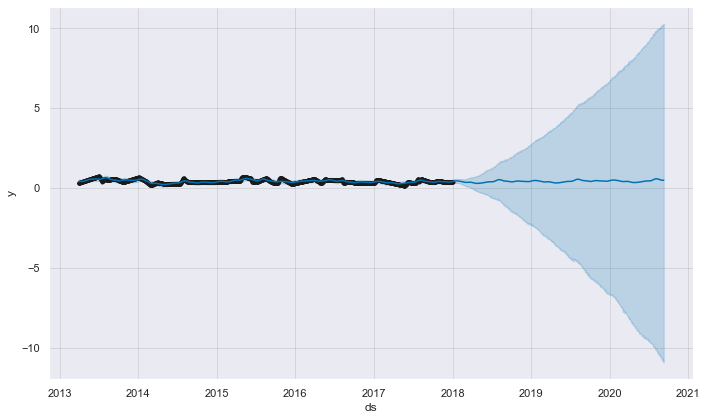

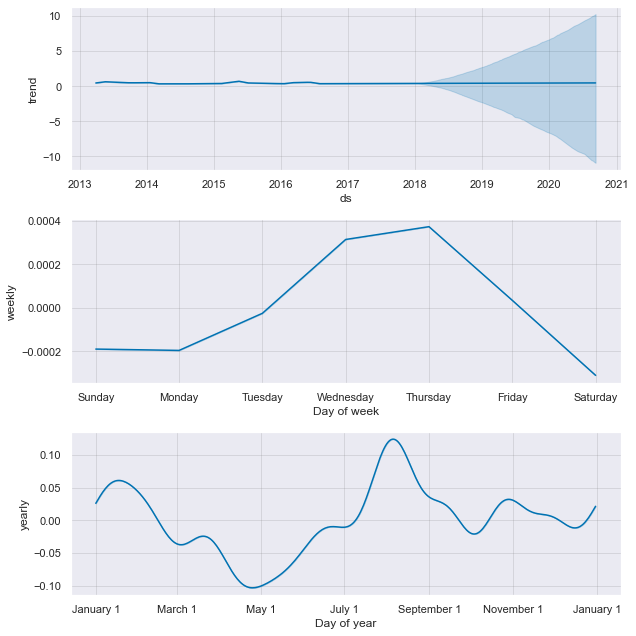

In [244]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m1.plot(forecast)
fig = m1.plot_components(forecast)

plt.grid(True)
plt.show()

- As we move away from 2018, NDVI has increasing trend. The confidence interval also widens as we move further from 2018
- The trend follows similar pattern as we have seen with ARIMA model
- Daily seasonlay does not make much sense for NDVI analysis
- The seasonality curve predicts NDVI starts to drop from January, hits the lowest in May, start rising till August and then dropping again which is also quite similar to ARIMA model

#### Look Closely on the Predicted Data

From 2018 to present

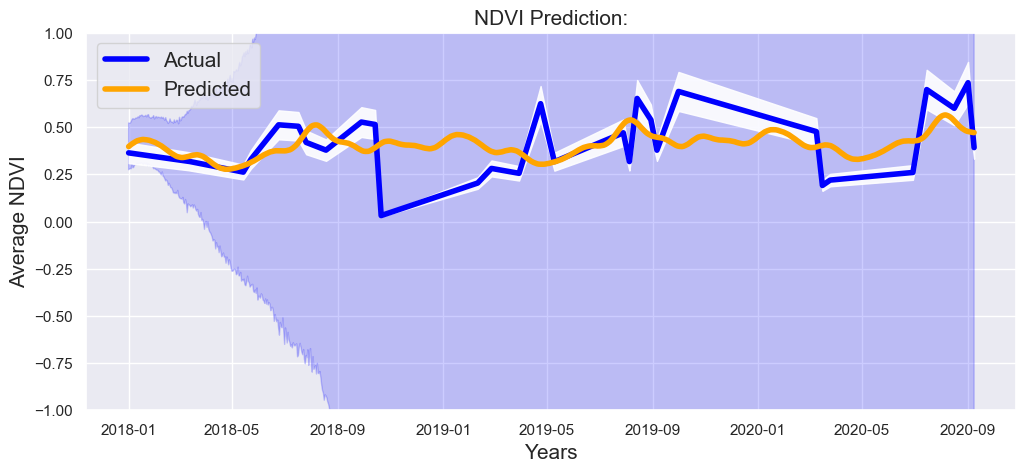

In [247]:
# plot only the train, test and forecast data for 2018-2020

fc_test = forecast[forecast.ds.isin(test_data.index)]

# take forecast data for 2018-2020

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual', linewidth=4)
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted', linewidth=4)
plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='blue', alpha=.2)
plt.title('NDVI Prediction:', fontsize=15)
plt.grid(True)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.ylim((-1,1))
plt.legend(loc='upper left', fontsize=15)
plt.fill_between(fc_test.ds,.85*test_data.ndvi,1.15*test_data.ndvi,
                 color='white', alpha=.90)
    
# save the plot
plt.show()

- The simple FBProphet captured more seasonality pattern than the ARIMA model
- Confidence level inproved compared to ARIMA model (narrowing of the shaded region)
- Visually predicted value aligns more with test data which will be quantified next
- Actual NDVI data is infrequent whereas model trains on the basis of daily observation. More frequent training data is expected to improve the prediction 

#### Model Performance

In [246]:
# performance measures for the FBProphet model

FBProphet = performance_measure('FBProphet', fc_test.yhat.values.flatten(), test_data.values.flatten())
FBProphet

,model,mse,mae,rmse,average_score
0,FBProphet,0.023743,0.122032,0.154087,0.099954


### Model Comparison

Combine results from all the models and compare results.

In [237]:
results = pd.concat([ARIMA, FBProphet], axis=0)

results.head()

,model,mse,mae,rmse,average_score
0,ARIMA,0.026408,0.136337,0.162506,0.108417
0,FBProphet,0.023743,0.122032,0.154087,0.099954


- FBProphet performed well compared to ARIMA in every metrics: 'mse', 'mae', 'rmse' and 'average_score'

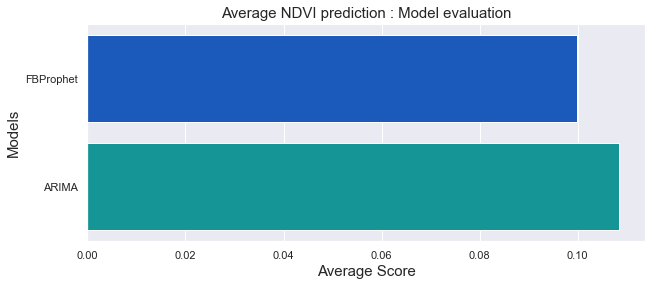

In [236]:
# Plot average Score

results_score = results.sort_values(by=['average_score'])

plt.figure(figsize=(10,4))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_score.average_score,
    y=results_score.model,
    data=results_score,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Average Score", fontsize=15)
plt.title("Average NDVI prediction : Model evaluation", fontsize=15)
plt.show()

- FBProphet improved average score by 7.85 % compared to ARIMA model

## 4. Conclusion
#### Summary

- Okanagan Valley's average NDVI values were extracted for 2013-2018 and predicted were made for the duration of 2018-present date
- Landsat 8 imageries were collected for the Okanagan region with maximum cloud coverage of 20%
- For the time-series NDVI analysis, Google Earth Engine was used through Python API
- For the time-series NDVI prediction, ARIMA and FBProphet libraries were used

**ARIMA**:
- Hyperparameters of ARIMA model were optimized using grid search method. The best parameters were found to be (p, d, q = 2 , 1, 0)
- Average_score for the best ARIMA model is 0.108417

**FBProphet**: 
- Model was trained for capturing major trend chage points for best curve fitting and prediction
- Average_score for the trained FBProphet model is 0.099954

Observations from trend, seasonality:

**Trend**: From 2015 to 2019 NDVI saw decreasing trend whereas from 2019 onward it is increasing
**Seasonality**: Both models suggested August is the peak NDVI month and in May NDVI drops to the lowest

**Which is the better model?**
FBProphet predicted NDVI captured more seasonality pattern than the ARIMA model. FBProphet improved 'average_score' by 7.85% which is reflected in the visualization as well.

#### Areas to Explore

- Apply cloud removal algorithms to get more frequent training data
- Apply classification algorithm to create vegetation only mask to more accurately calculate NDVI 
- Look for satellite imagery with shortest revisit time to increase training data volume
- Identy special events that triggered change in NDVI data such as natural disaster, drought or forest fire. This can be included in FBProphet model for much more robust prediction 
- Error in prediction can be identified and add as a regressor for FBProphet prediction